In [15]:
import torch
import torch.nn as nn
from sklearn.datasets import make_circles,make_moons,make_classification
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [9]:
class LinearClassifier(nn.Module):
    def __init__(self, in_dimension: int):
        super().__init__()
        self.in_dimension=in_dimension
        self.linear=nn.Linear(in_dimension,1)
        self.sigmoid=nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.sigmoid(self.linear(x))

In [10]:
def linear_dataset(n_per_class=250):
    x1_points=np.linspace(-1,1,n_per_class)
    x=np.zeros((2*n_per_class,2))
    y=np.zeros(2*n_per_class)

    for k in range(n_per_class):
        sf_x=np.random.randint(2,10)
        sf_y=np.random.choice(np.arange(2,4))
        x[2*k,:]=[x1_points[k]+(2*np.random.random()-1)/sf_x,0.5+(2*np.random.random()-1)/sf_y]
        x[2*k+1,:]=[x1_points[k]+(2*np.random.random()-1)/sf_x,-0.5+(2*np.random.random()-1)/sf_y]
        y[2*k+1]=1

    for k in range(x.shape[0]):
        if y[k]==1:
            x[k,1]=(x[k,1]-1)/2
        else:
            x[k,1]=(x[k,1]+1)/2
    return x,y

def vee_dataset(n_per_class=250):
    x_points=np.linspace(-1,1,n_per_class)

    x=np.zeros((2*n_per_class,2))
    y=np.zeros(2*n_per_class)

    for k in range(n_per_class):
        x[2*k,:]=[x_points[k]+(2*np.random.random()-1)/10,np.abs(x_points[k]+(2*np.random.random()-1)/10)]
        x[2*k+1,:]=[x_points[k]+(2*np.random.random()-1)/10,np.abs(x_points[k]+(2*np.random.random()-1)/10)+0.5]
        y[2*k+1]=1
    return x,y

def circles_dataset(n_per_class=250):
    data=make_circles(2*n_per_class,noise=0.05,factor=0.5)
    x=data[0]
    y=data[1]
    return x,y

def curved_dataset(n_per_class=250):
    data=make_moons(2*n_per_class,noise=0.1)
    x=data[0]
    y=data[1]
    return x,y

In [11]:
def rotate_2d(vector,theta):
    rotation_matrix=np.zeros((2,2))
    rotation_matrix[0,0]=rotation_matrix[1,1]=np.cos(theta)
    rotation_matrix[0,1]=np.sin(theta)
    rotation_matrix[1,0]=-np.sin(theta)
    return np.matmul(rotation_matrix,vector)

In [47]:
def concept_vector_loss_variation_2d(dataset_name):
    with tqdm(total=1) as pbar:
        if dataset_name=='linear':
            x,y=linear_dataset()
        elif dataset_name=='vee':
            x,y=vee_dataset()
        elif dataset_name=='curved':
            x,y=curved_dataset()
        elif dataset_name=='circles':
            x,y=circles_dataset()
        elif dataset_name=='classification':
            x,y=make_classification(n_samples=500,n_features=2,n_informative=2,n_redundant=0,n_classes=2,n_clusters_per_class=1,class_sep=4)
        else:
            raise ValueError('Enter valid dataset name, linear,vee,curved,circles')
    
        x_means=np.mean(x,axis=0)
        x_maxs=np.max(x,axis=0)
        x=x-x_means
        x/=x_maxs

        x=torch.tensor(x).float()
        y=torch.tensor(y).float().unsqueeze(1)

        num_epochs=100
        batch_size=16
        lr=1e-2
        num_steps=10000
        dataset_size=x.shape[0]

        cav_model=LinearClassifier(2)
        opt=torch.optim.Adam(cav_model.parameters(),lr=lr)
        criterion=nn.BCELoss()

        for epoch in range(num_epochs):
            epoch_cycles=dataset_size//batch_size
            epoch_loss=0
            for cycle in range(epoch_cycles+1):
                if cycle==epoch_cycles:
                    inputs=x[cycle*batch_size:,:]
                    targets=y[cycle*batch_size:]
                else:
                    inputs=x[cycle*batch_size:(cycle+1)*batch_size,:]
                    targets=y[cycle*batch_size:(cycle+1)*batch_size]
                opt.zero_grad()
                outputs=cav_model(inputs)
                loss=criterion(outputs,targets)
                loss.backward()
                opt.step()
                epoch_loss+=loss*len(targets)
            pbar.set_description(f'Epoch {epoch+1}/{num_epochs}: loss={epoch_loss/dataset_size:.4f}')
        cav_loss=(epoch_loss/dataset_size).item()

        angles=np.linspace(-np.pi,np.pi,1000)

        cav=cav_model.linear.weight.detach()[0]
        bias=cav_model.linear.bias.detach()
        angles=np.linspace(-np.pi,np.pi,100)
        pbar.set_description(f'...computing rotated CAV losses...')
        cav_losses=[]
        for angle in angles:
            rotated_cav=rotate_2d(cav.numpy(),angle)
            model_with_rotated_cav=LinearClassifier(2)
            with torch.no_grad():
                model_with_rotated_cav.linear.weight=nn.Parameter(torch.tensor(rotated_cav).float().unsqueeze(0))
                model_with_rotated_cav.linear.bias=nn.Parameter(bias)
            model_with_rotated_cav.eval()
            epoch_loss=0
            epoch_cycles=dataset_size//batch_size
            for cycle in range(epoch_cycles+1):
                if cycle==epoch_cycles:
                    inputs=x[cycle*batch_size:,:]
                    targets=y[cycle*batch_size:]
                else:
                    inputs=x[cycle*batch_size:(cycle+1)*batch_size,:]
                    targets=y[cycle*batch_size:(cycle+1)*batch_size]
                outputs=model_with_rotated_cav(inputs)
                loss=criterion(outputs,targets)
                epoch_loss+=loss*len(targets)
            epoch_loss/=dataset_size
            cav_losses.append((epoch_loss).item())   

        pbar.set_description('...getting pairs...')

        positive_latents=x[y.T[0]==1,:]
        negative_latents=x[y.T[0]==0,:]

        pairs_from_positive=[]
        negative_idxs=[]

        for k in range(positive_latents.shape[0]):
            positive_latent=positive_latents[k,:]
            distances=np.zeros(negative_latents.shape[0])
            for l in range(negative_latents.shape[0]):
                distances[l]=torch.norm(positive_latent-negative_latents[l,:])
            pairs_from_positive.append([k,distances.argmin()])
            negative_idxs.append(distances.argmin())

        negative_idxs=list(set(negative_idxs))

        positive_idxs=[]
        pairs_from_negative=[]

        for k in range(negative_latents.shape[0]):
            negative_latent=negative_latents[k,:]
            distances=np.zeros(positive_latents.shape[0])
            for l in range(positive_latents.shape[0]):
                distances[l]=torch.norm(negative_latent-positive_latents[l,:])
            pairs_from_negative.append([distances.argmin(),k])
            positive_idxs.append(distances.argmin())

        positive_idxs=list(set(positive_idxs))

        pairs=[]

        for pair in pairs_from_positive:
            if pair[0] in positive_idxs:
                pairs.append(pair)
        
        for pair in pairs_from_negative:
            if pair[1] in negative_idxs:
                if not(pair in pairs):
                    pairs.append(pair)

        for n,pair in enumerate(pairs):
            positive_latent=positive_latents[pair[0],:]
            negative_latent=negative_latents[pair[1],:]
            if n==0:
                normals=(positive_latent-negative_latent).unsqueeze(0)
            else:
                normals=torch.cat([normals,(positive_latent-negative_latent).unsqueeze(0)])

        optimized_vector=torch.rand((normals.shape[1]))
        optimized_vector=(optimized_vector/torch.norm(optimized_vector)).requires_grad_()

        norm_opt=torch.optim.SGD([optimized_vector],lr=lr)

        steps=0
        cumulative_loss=0
        while steps<num_steps:
            epoch_loss=0
            for k in range(normals.shape[0]):
                norm_opt.zero_grad()
                dot=torch.dot(optimized_vector,normals[k,:])/torch.norm(optimized_vector)
                loss=torch.abs(1-dot)
                loss.backward()
                norm_opt.step()
                cumulative_loss+=loss.item()
                steps+=1
                epoch_loss+=loss.item()
                if steps%100==0:
                    pbar.set_description(f'Step {steps}: loss={(cumulative_loss/steps):.4f}')
            epoch_loss/=normals.shape[0]
        cbv_loss=epoch_loss/normals.shape[0]

        optimized_vector=optimized_vector.detach()
        pbar.set_description(f'...computing rotated CBV losses...')
        cbv_losses=[]
        for angle in angles:
            rotated_cbv=torch.tensor(rotate_2d(optimized_vector.numpy(),angle)).float().detach()
            epoch_loss=0
            for k in range(normals.shape[0]):
                dot=torch.dot(rotated_cbv,normals[k,:])/torch.norm(rotated_cbv)
                loss=torch.abs(1-dot)
                epoch_loss+=loss.item()
            epoch_loss/=normals.shape[0]
            cbv_losses.append(epoch_loss)

    return angles,cav_losses,cbv_losses

...computing rotated CBV losses...:   0%|          | 0/1 [00:09<?, ?it/s]


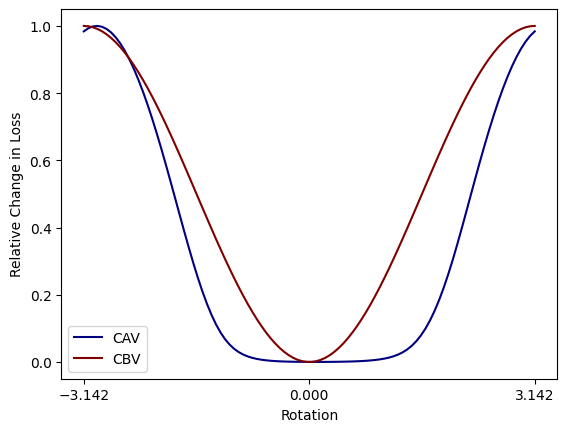

In [54]:
dataset_name='classification'
angles,cav_losses,cbv_losses=concept_vector_loss_variation_2d(dataset_name)
colors=plt.cm.jet(np.linspace(0,1,2))
plt.plot(angles,[(loss-min(cav_losses))/(max(cav_losses)-min(cav_losses)) for loss in cav_losses],label='CAV',color=colors[0])
plt.plot(angles,[(loss-min(cbv_losses))/(max(cbv_losses)-min(cbv_losses)) for loss in cbv_losses],label='CBV',color=colors[1])
plt.xticks([-np.pi,0,np.pi])
plt.ylabel('Relative Change in Loss')
plt.xlabel('Rotation')
plt.legend()

In [30]:
def rotate_3d(vector,theta,psi):
    rotation_matrix_theta=np.eye(3)
    rotation_matrix_theta[0,0]=rotation_matrix_theta[1,1]=np.cos(theta)
    rotation_matrix_theta[0,1]=np.sin(theta)
    rotation_matrix_theta[1,0]=-np.sin(theta)

    rotation_matrix_psi=np.eye(3)
    rotation_matrix_psi[0,0]=rotation_matrix_psi[2,2]=np.cos(psi)
    rotation_matrix_psi[0,2]=np.sin(psi)
    rotation_matrix_psi[2,0]=-np.sin(psi)
    return np.matmul(np.matmul(rotation_matrix_theta,rotation_matrix_psi),vector)

In [38]:
def concept_vector_loss_variation_3d():
    with tqdm(total=1) as pbar:
        x,y=make_classification(n_samples=500,n_features=3,n_informative=3,n_redundant=0,n_classes=2,n_clusters_per_class=1,class_sep=4)
        x_means=np.mean(x,axis=0)
        x_maxs=np.max(x,axis=0)
        x=x-x_means
        x/=x_maxs

        x=torch.tensor(x).float()
        y=torch.tensor(y).float().unsqueeze(1)

        num_epochs=100
        batch_size=16
        lr=1e-2
        num_steps=10000
        dataset_size=x.shape[0]

        cav_model=LinearClassifier(3)
        opt=torch.optim.Adam(cav_model.parameters(),lr=lr)
        criterion=nn.BCELoss()

        for epoch in range(num_epochs):
            epoch_cycles=dataset_size//batch_size
            epoch_loss=0
            for cycle in range(epoch_cycles+1):
                if cycle==epoch_cycles:
                    inputs=x[cycle*batch_size:,:]
                    targets=y[cycle*batch_size:]
                else:
                    inputs=x[cycle*batch_size:(cycle+1)*batch_size,:]
                    targets=y[cycle*batch_size:(cycle+1)*batch_size]
                opt.zero_grad()
                outputs=cav_model(inputs)
                loss=criterion(outputs,targets)
                loss.backward()
                opt.step()
                epoch_loss+=loss*len(targets)
            pbar.set_description(f'Epoch {epoch+1}/{num_epochs}: loss={epoch_loss/dataset_size:.4f}')
        cav_loss=(epoch_loss/dataset_size).item()

        angles=[]
        angles_theta=np.linspace(-np.pi,np.pi,100)
        angles_psi=np.linspace(-np.pi,np.pi,100)

        cav=cav_model.linear.weight.detach()[0]
        bias=cav_model.linear.bias.detach()

        cav_losses=[]
        pbar.set_description(f'...computing rotated CAV losses...')
        for theta in angles_theta:
            for psi in angles_psi:
                angles.append([theta,psi])
                rotated_cav=rotate_3d(cav.numpy(),theta,psi)
                model_with_rotated_cav=LinearClassifier(2)
                with torch.no_grad():
                    model_with_rotated_cav.linear.weight=nn.Parameter(torch.tensor(rotated_cav).float().unsqueeze(0))
                    model_with_rotated_cav.linear.bias=nn.Parameter(bias)
                model_with_rotated_cav.eval()
                epoch_loss=0
                epoch_cycles=dataset_size//batch_size
                for cycle in range(epoch_cycles+1):
                    if cycle==epoch_cycles:
                        inputs=x[cycle*batch_size:,:]
                        targets=y[cycle*batch_size:]
                    else:
                        inputs=x[cycle*batch_size:(cycle+1)*batch_size,:]
                        targets=y[cycle*batch_size:(cycle+1)*batch_size]
                    outputs=model_with_rotated_cav(inputs)
                    loss=criterion(outputs,targets)
                    epoch_loss+=loss*len(targets)
                epoch_loss/=dataset_size
                cav_losses.append((epoch_loss).item())   

        pbar.set_description('...getting pairs...')

        positive_latents=x[y.T[0]==1,:]
        negative_latents=x[y.T[0]==0,:]

        pairs_from_positive=[]
        negative_idxs=[]

        for k in range(positive_latents.shape[0]):
            positive_latent=positive_latents[k,:]
            distances=np.zeros(negative_latents.shape[0])
            for l in range(negative_latents.shape[0]):
                distances[l]=torch.norm(positive_latent-negative_latents[l,:])
            pairs_from_positive.append([k,distances.argmin()])
            negative_idxs.append(distances.argmin())

        negative_idxs=list(set(negative_idxs))

        positive_idxs=[]
        pairs_from_negative=[]

        for k in range(negative_latents.shape[0]):
            negative_latent=negative_latents[k,:]
            distances=np.zeros(positive_latents.shape[0])
            for l in range(positive_latents.shape[0]):
                distances[l]=torch.norm(negative_latent-positive_latents[l,:])
            pairs_from_negative.append([distances.argmin(),k])
            positive_idxs.append(distances.argmin())

        positive_idxs=list(set(positive_idxs))

        pairs=[]

        for pair in pairs_from_positive:
            if pair[0] in positive_idxs:
                pairs.append(pair)
        
        for pair in pairs_from_negative:
            if pair[1] in negative_idxs:
                if not(pair in pairs):
                    pairs.append(pair)

        for n,pair in enumerate(pairs):
            positive_latent=positive_latents[pair[0],:]
            negative_latent=negative_latents[pair[1],:]
            if n==0:
                normals=(positive_latent-negative_latent).unsqueeze(0)
            else:
                normals=torch.cat([normals,(positive_latent-negative_latent).unsqueeze(0)])

        optimized_vector=torch.rand((normals.shape[1]))
        optimized_vector=(optimized_vector/torch.norm(optimized_vector)).requires_grad_()

        norm_opt=torch.optim.SGD([optimized_vector],lr=lr)

        steps=0
        cumulative_loss=0
        while steps<num_steps:
            epoch_loss=0
            for k in range(normals.shape[0]):
                norm_opt.zero_grad()
                dot=torch.dot(optimized_vector,normals[k,:])/torch.norm(optimized_vector)
                loss=torch.abs(1-dot)
                loss.backward()
                norm_opt.step()
                cumulative_loss+=loss.item()
                steps+=1
                epoch_loss+=loss.item()
                if steps%100==0:
                    pbar.set_description(f'Step {steps}: loss={(cumulative_loss/steps):.4f}')
            epoch_loss/=normals.shape[0]
        cbv_loss=epoch_loss/normals.shape[0]

        optimized_vector=optimized_vector.detach()
        pbar.set_description(f'...computing rotated CBV losses...')
        cbv_losses=[]
        for theta in angles_theta:
            for psi in angles_psi:
                rotated_cbv=torch.tensor(rotate_3d(optimized_vector.numpy(),theta,psi)).float().detach()
                epoch_loss=0
                for k in range(normals.shape[0]):
                    dot=torch.dot(rotated_cbv,normals[k,:])/torch.norm(rotated_cbv)
                    loss=torch.abs(1-dot)
                    epoch_loss+=loss.item()
                epoch_loss/=normals.shape[0]
                cbv_losses.append(epoch_loss)

    return angles,cav_losses,cbv_losses

...computing rotated CBV losses...:   0%|          | 0/1 [00:50<?, ?it/s]


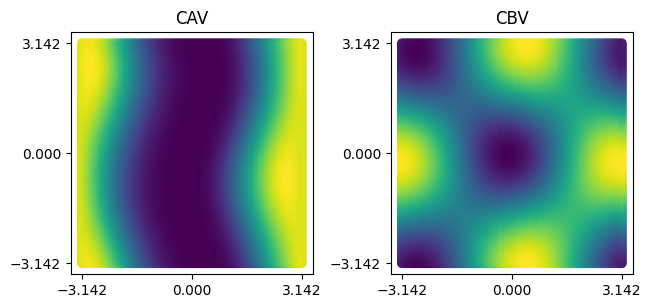

In [46]:
angles,cav_losses,cbv_losses=concept_vector_loss_variation_3d()
angles=np.array(angles)
fig,axs=plt.subplots(nrows=1,ncols=2,layout='constrained')
axs[0].scatter(angles[:,0],angles[:,1],c=cav_losses)
axs[0].set_yticks([-np.pi,0,np.pi])
axs[0].set_xticks([-np.pi,0,np.pi])
axs[0].set_aspect('equal')
axs[0].set_title('CAV')

axs[1].scatter(angles[:,0],angles[:,1],c=cbv_losses)
axs[1].set_yticks([-np.pi,0,np.pi])
axs[1].set_xticks([-np.pi,0,np.pi])
axs[1].set_aspect('equal')
axs[1].set_title('CBV')
plt.show()